In [1]:
# Along-fjord Layer Properties
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
# Find the layer interface
def Layer_S(Szx):
    #Szx = State.S.data.mean(axis=(0,2))
    Sma = np.ma.masked_where(Szx==0, Szx)
    X = Szx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0]] = 0 # Remove data at fjord head
    for i in range(1,len(X)):
        meanS = np.abs(Sma[:,i] - (Sma[:,i].max() + Sma[:,i].min()) / 2)
        itf[i] = np.argmin(meanS)
    return itf

In [3]:
# Find the interface
def Layer_U(Uzx):
    # Layer interface, zero velocity crossing point
    X = Uzx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0]] = 0 # Remove data at fjord head and end
    for i in range(1,X):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [4]:
def DynamicalP(Qsg, hs):
      
#     File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/grid_' + str(format(hs,'03d')) + '.nc')
#     File02 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc')
    File1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/state_' + str(format(case_id,'03d'))
    File02 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/state_' + str(format(case_id,'03d'))

#     T0 = 89 # or 81/275 for one/two week run
#     Tn = len(File2.T)
#     Grid = File1.isel(X=range(120), Xp1=range(121), Y=range(30,39))
#     State = File2.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(T0,Tn))
    File2 = File02.isel(T=~File02.get_index("T").duplicated())
    T0 = 90
    Tn = len(File2.T)
    Grid = File1.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    State = File2.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45), T=range(T0,Tn))

    x = Grid.X.data
    z = Grid.Z.data
    drF = Grid.drF.data # r cell face separation
    HFacC = Grid.HFacC.data.mean(1) # vertical fraction of open cell at cell center
    U = State.U.data.mean(axis=(0,2))
    u = (U[:, 1:] + U[:, :-1]) / 2
    s = State.S.data.mean(axis=(0,2)) # Salinity
    pt = State.Temp.data.mean(axis=(0,2)) # Potential temperature
    pres = gsw.p_from_z(z, 55)
    p = np.tile(pres,[len(x),1]).T
    rho = gsw.rho(s, pt, p) # Density
    g = 9.81
    
    Sma = np.ma.masked_where(s==0, s)
    s1 = np.empty(len(x))
    s2 = np.empty(len(x))
    u1 = np.empty(len(x))
    u2 = np.empty(len(x))
    F1 = np.empty(len(x))
    F2 = np.empty(len(x))
    L = np.empty(len(x))
    for i in range(1,len(x)):
        gh = drF * HFacC[:,i] # grid height
        meanS = np.abs(Sma[:,i] - (Sma[:,i].max() + Sma[:,i].min()) / 2)
        #l = np.argmin(meanS) # index of the layer interface
        l = np.where(u[:, i] < 0)[-1][0]
        h1 = gh[:l].sum()    
        h2 = gh[l+1:].sum()
        s1[i] = np.sum(s[:l,i] * gh[:l]) / h1
        s2[i] = np.sum(s[l+1:,i] * gh[l+1:]) / h2
        u1[i] = np.sum(u[:l,i] * gh[:l]) / h1
        u2[i] = np.sum(u[l+1:,i] * gh[l+1:]) / h2
        
        rho1 = np.sum(rho[:l,i] * gh[:l]) / h1
        rho2 = np.sum(rho[l+1:,i] * gh[l+1:]) / h2
        gr = g * (rho2-rho1) / rho2 # Reduced gravity
        F1[i] = u1[i] / np.sqrt(gr*h1)
        F2[i] = u2[i] / np.sqrt(gr*h2)
        L[i] = gr
    return (s1, s2, u1, u2, F1, F2)

In [ ]:
#s1, s2, u1, u2, F1, F2, L = DynamicalP(500,3)


In [ ]:
Qsg = 500
hs = 2
X = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc').X.data[:120]
Xp = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc').Xp1.data[:121]
s1, s2, u1, u2, F1, F2 = DynamicalP(Qsg,hs)
G = np.sqrt(F1**2 + F2**2) # Composite Froude number

# Make plots
fig1 = plt.figure(figsize=(15,9))
fig1.tight_layout()

ax1 = fig1.add_subplot(311)
ax1.plot(X[1:],F1[1:],'-r',linewidth=2,label='Upper layer')
ax1.plot(X[1:],-F2[1:],'-b',linewidth=2, label='Lower layer')
ax1.plot(X[1:],G[1:],'--g',linewidth=2)
ax1.legend(fontsize=15, loc="right")
ax1.axhline(y=1, color='k',lw=.5)
ax1.axvline(x=4800, color='k', linestyle='--')
ax1.axvline(x=5800, color='k', linestyle='--')
plt.ylabel(r'Froude number', size=15)
ax1.axes.get_xaxis().set_visible(False)
#ax1.spines['left'].set_linewidth(2)
#ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim([0, 10000])
ax1.set_ylim([0, 1.2])
ax1.set_title(r'$h_s/h=$'+str(hs/150), loc='center', size=20)

P = s2 / (s2-s1)
Pmean = P[1:].mean()
ax2 = fig1.add_subplot(312)
ax2.plot(X[1:],s1[1:],'-r',linewidth=2)
ax2.plot(X[1:],s2[1:],'-b',linewidth=2)
#ax2.plot(X[1:],P[1:],'-b',linewidth=2)
#ax2.axhline(y=Pmean, color='k',lw=.5)

ax2.axvline(x=4800, color='k', linestyle='--')
ax2.axvline(x=5800, color='k', linestyle='--')
plt.ylabel(r'Layer Sanility (g/kg)', size=15)
ax2.axes.get_xaxis().set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim([0, 10000])

ax3 = fig1.add_subplot(313)
ax3.plot(X[1:],u1[1:],'-r',linewidth=2)
ax3.plot(X[1:],u2[1:],'-b',linewidth=2)
ax3.axvline(x=4800, color='k', linestyle='--')
ax3.axvline(x=5800, color='k', linestyle='--')
plt.ylabel(r'Layer Velocity (m/s)', size=15)
#ax3.tick_params(axis='x', labelsize=15)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlim([0, 10000])
ax3.set_xlabel(r'Distance from glacier (m)', size=15)
#X[48:72], Xp[48:73], Xp[72] - Xp[48]
#s1 ,s2
plt.show()

In [ ]:
dist = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '/state_001.nc').X.data[:120]
len(dist)

In [5]:

qsg = 250
hs = np.array([1,2,3,4,5])
hsr = np.array([0.04,0.06,0.08,0.10,0.12])
dist = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(qsg,'03d')) + '/state_001.nc').X.data[:260] / 1000

Fr1 = np.empty([len(hs), len(dist)])
Fr2 = np.empty([len(hs), len(dist)])
S1 = np.empty([len(hs), len(dist)])
S2 = np.empty([len(hs), len(dist)])
U1 = np.empty([len(hs), len(dist)])
U2 = np.empty([len(hs), len(dist)])

for j in range(len(hs)):
    S1[j,:], S2[j,:], U1[j,:], U2[j,:], Fr1[j,:], Fr2[j,:] = DynamicalP(qsg,hs[j])
    

In [ ]:
Fr2

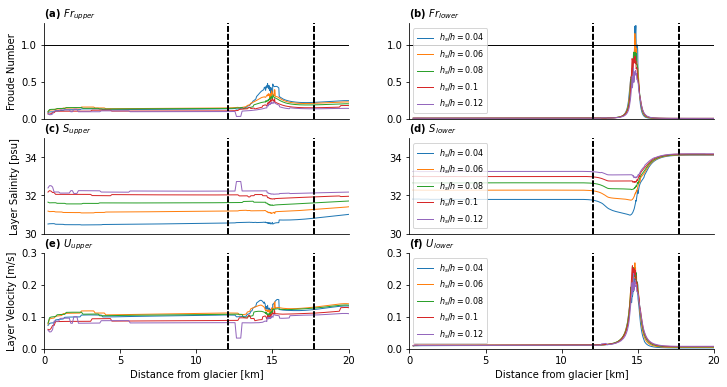

In [8]:
x0 = 2
Fr1[:,:x0] = 'nan'
Fr2[:,:x0] = 'nan'
S1[:,:x0] = 'nan'
S2[:,:x0] = 'nan'
U1[:,:x0] = 'nan'
U2[:,:x0] = 'nan'

fig2 = plt.figure(figsize=(12,6))
fig2.tight_layout()

ax1 = fig2.add_subplot(321)
ax2 = fig2.add_subplot(322)
ax3 = fig2.add_subplot(323)
ax4 = fig2.add_subplot(324)
ax5 = fig2.add_subplot(325)
ax6 = fig2.add_subplot(326)

for k in range(len(hs)):
    ax1.plot(dist,Fr1[k,:],lw=1,label=r'$h_s/h=$'+str(hsr[k]))
    #ax1.legend(fontsize=10, loc="upper left")
    ax1.axhline(y=1, color='k',lw=.5)
#     ax1.axvline(x=dist[47], color='k', linestyle='--')
#     ax1.axvline(x=dist[97], color='k', linestyle='--')
    ax1.axvline(x=dist[120], color='k', linestyle='--')
    ax1.axvline(x=dist[235], color='k', linestyle='--')
    ax1.set_ylabel(r'Froude Number',size= 10)
#     ax1.set_xlim([0, 9])
#     ax1.set_ylim([0, 1.1])
    ax1.set_xlim([0, 20])
    ax1.set_ylim([0, 1.3])
    ax1.xaxis.set_visible(False) # This erases the y ticks
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('(a) $Fr_{upper}$', loc='left', size=10, weight='bold')
    
    ax2.plot(dist,-Fr2[k,:],lw=1,label=r'$h_s/h=$'+str(hsr[k]))
    ax2.legend(fontsize=8, loc="center left")
    ax2.axhline(y=1, color='k',lw=.5)
    ax2.axvline(x=dist[120], color='k', linestyle='--')
    ax2.axvline(x=dist[235], color='k', linestyle='--')
    #ax2.set_ylabel('($m^3/s$)',size = 15)
#     ax2.set_xlim([0, 9])
#     ax2.set_ylim([0, 1.1])
    ax2.set_xlim([0, 20])
    ax2.set_ylim([0, 1.3])
    ax2.xaxis.set_visible(False) # This erases the y ticks
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title('(b) $Fr_{lower}$', loc='left', size=10, weight='bold')
    
    ax3.plot(dist,S1[k,:],lw=1, label=r'$h_s/h=$'+str(hsr[k]))
    #ax3.legend(fontsize=6, loc="upper left")
    ax3.axvline(x=dist[120], color='k', linestyle='--')
    ax3.axvline(x=dist[235], color='k', linestyle='--')
    ax3.set_ylabel(r'Layer Salinity [psu]',size = 10)
#     ax3.set_xlim([0, 9])
#     ax3.set_ylim([22, 35])
    ax3.set_xlim([0, 20])
    ax3.set_ylim([30, 35])
    ax3.xaxis.set_visible(False) # This erases the y ticks
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_title('(c) $S_{upper}$', loc='left', size=10, weight='bold')
    
    ax4.plot(dist,S2[k,:],lw=1, label=r'$h_s/h=$'+str(hsr[k]))
    ax4.legend(fontsize=8, loc="center left")
    ax4.axvline(x=dist[120], color='k', linestyle='--')
    ax4.axvline(x=dist[235], color='k', linestyle='--')
#     ax4.set_xlim([0, 9])
#     ax4.set_ylim([22, 35])
    ax4.set_xlim([0, 20])
    ax4.set_ylim([30, 35])
    ax4.xaxis.set_visible(False) # This erases the y ticks
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.set_title('(d) $S_{lower}$', loc='left', size=10, weight='bold')
    
    ax5.plot(dist,U1[k,:],lw=1, label=r'$h_s/h=$'+str(hsr[k]))
    #ax5.legend(fontsize=6, loc="upper left")
    ax5.axvline(x=dist[120], color='k', linestyle='--')
    ax5.axvline(x=dist[235], color='k', linestyle='--')
    ax5.set_xlabel(r'Distance from glacier [km]',size = 10)
    ax5.set_ylabel(r'Layer Velocity [m/s]',size = 10)
#     ax5.set_xlim([0, 9])
#     ax5.set_xticks([0, 3, 6, 9])
#     ax5.set_ylim([0, .35])
    ax5.set_xlim([0, 20])
    ax5.set_xticks([0, 5, 10, 15, 20])
    ax5.set_ylim([0, .3])
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    ax5.set_title('(e) $U_{upper}$', loc='left', size=10, weight='bold')
    
    ax6.plot(dist,-U2[k,:],lw=1, label=r'$h_s/h=$'+str(hsr[k]))
    ax6.legend(fontsize=8, loc="center left")
    ax6.axvline(x=dist[120], color='k', linestyle='--')
    ax6.axvline(x=dist[235], color='k', linestyle='--')
    ax6.set_xlabel(r'Distance from glacier [km]',size = 10)
#     ax6.set_xlim([0, 9])
#     ax6.set_xticks([0, 3, 6, 9])
#     ax6.set_ylim([0, .35])
    ax6.set_xlim([0, 20])
    ax6.set_xticks([0, 5, 10, 15, 20])
    ax6.set_ylim([0, .3])
    ax6.spines['top'].set_visible(False)
    ax6.spines['right'].set_visible(False)
    ax6.set_title('(f) $U_{lower}$', loc='left', size=10, weight='bold')
    
    #ax4.plot(dist[1:],S2[k,1:],lw=1)
    
    #ax5.plot(dist[1:],U1[k,1:],lw=1)
    
    #ax6.plot(dist[1:],U2[k,1:],lw=1)
    
plt.show()    

In [9]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Parameter/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig2.savefig(fig_path + '/Dynamics_hs.png', dpi=200, bbox_inches='tight')
#fig2.savefig(fig_path + '/Mom_mag.png', dpi=200, bbox_inches='tight')